In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [3]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [3]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [4]:
basketball

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
0,Precious Achiuwa,PF-C,24,TOT,74,18,1624,235,469,0.501,...,191,296,487,97,46,68,83,143,565,achiupr01
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,Thaddeus Young,PF,35,TOT,33,6,439,65,108,0.602,...,46,57,103,57,23,5,15,49,137,youngth01
568,Trae Young,PG,25,ATL,54,54,1942,433,1008,0.430,...,23,126,149,583,72,11,235,109,1389,youngtr01
569,Omer Yurtseven,C,25,UTA,48,12,545,99,184,0.538,...,72,136,208,29,8,18,37,52,222,yurtsom01
570,Cody Zeller,C,31,NOP,43,0,320,26,62,0.419,...,48,64,112,39,9,5,16,45,76,zelleco01


**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

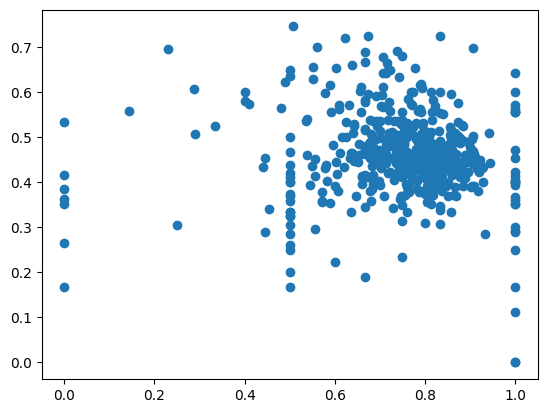

In [7]:
plt.scatter(x=(basketball.FT/basketball.FTA), y=(basketball.FG/basketball.FGA))

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

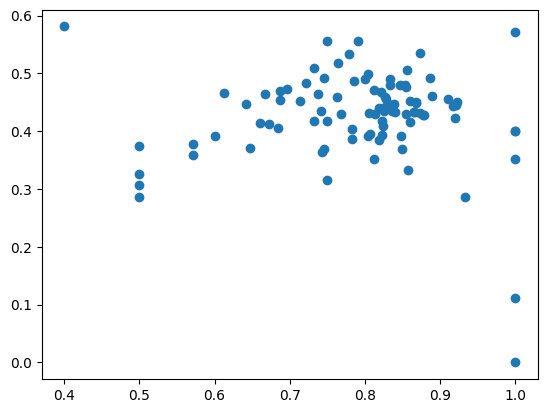

In [14]:
basketballPG = basketball.query('Pos == "PG"')
basketballSG = basketball.query('Pos == "SG"')
basketballSF = basketball.query('Pos == "SF"')
basketballPF = basketball.query('Pos == "PF"')
basketballC = basketball.query('Pos == "C"')
plt.scatter(x=(basketballPG.FT/basketballPG.FTA), y=(basketballPG.FG/basketballPG.FGA))
#plt.scatter(x=(basketballSG.FT/basketballSG.FTA), y=(basketballSG.FG/basketballSG.FGA))
#plt.scatter(x=(basketballSF.FT/basketballSF.FTA), y=(basketballSF.FG/basketballSF.FGA))
#plt.scatter(x=(basketballPF.FT/basketballPF.FTA), y=(basketballPF.FG/basketballPF.FGA))
#plt.scatter(x=(basketballC.FT/basketballC.FTA), y=(basketballC.FG/basketballC.FGA))

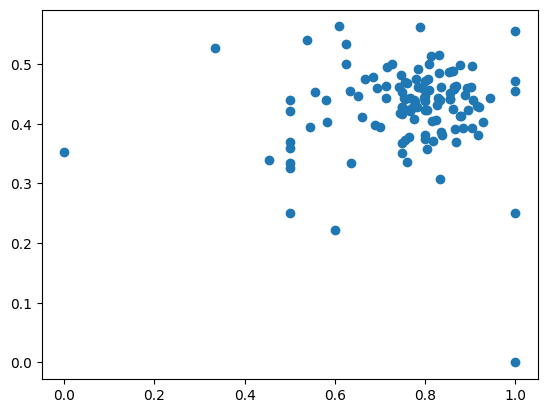

In [15]:
plt.scatter(x=(basketballSG.FT/basketballSG.FTA), y=(basketballSG.FG/basketballSG.FGA))

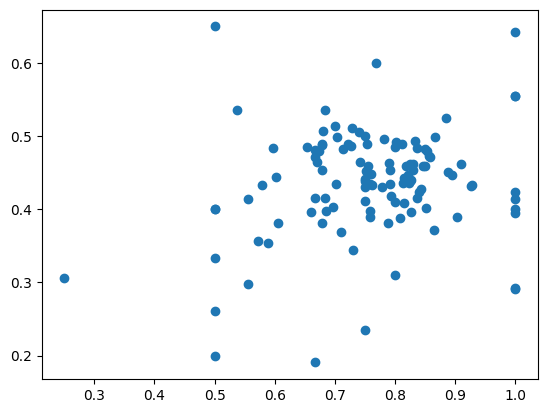

In [16]:
plt.scatter(x=(basketballSF.FT/basketballSF.FTA), y=(basketballSF.FG/basketballSF.FGA))

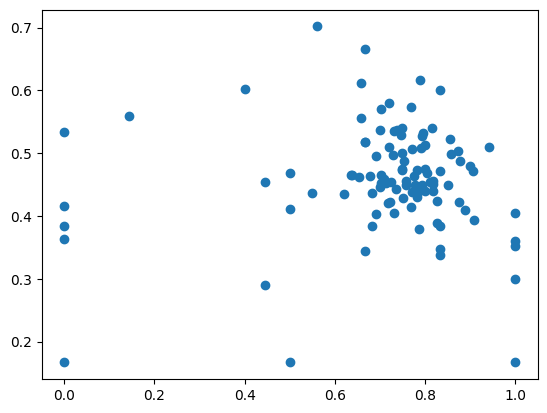

In [17]:
plt.scatter(x=(basketballPF.FT/basketballPF.FTA), y=(basketballPF.FG/basketballPF.FGA))

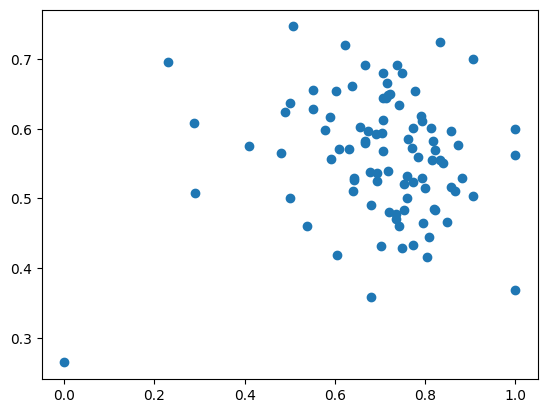

In [18]:
plt.scatter(x=(basketballC.FT/basketballC.FTA), y=(basketballC.FG/basketballC.FGA))

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

One reason could be the non-linearity of the data caused by outliers and groupings of datapoints around 0.5 and 1.0. If you look at the SF scatter plot you can see the groupings of datapoints around 0.5 and 1.0 which would make a it hard to make a linear regression model fit. The other problem is outliers, if you look at the PF scatter plot there are a lot of outliers around the edges of the graph making it hard for a linear regression model to work.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [4]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [5]:
howell

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


**Task4**:

Make a scatter plot of height versus weight for the howell data set.

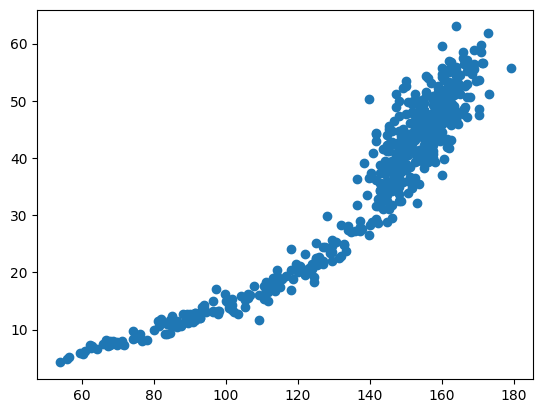

In [21]:
plt.scatter(x=howell.height, y=howell.weight)

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [35]:
with pm.Model() as howell_model:
  α = pm.Normal("α", sigma=5)
  β = pm.Normal("β", sigma=5)

  μ = pm.Deterministic("μ", α + β * howell.height)

  σ = pm.HalfNormal("σ", sigma = 5)

  y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

  idata_lba = pm.sample()

Output()

Output()

Text(0, 0.5, 'weight')

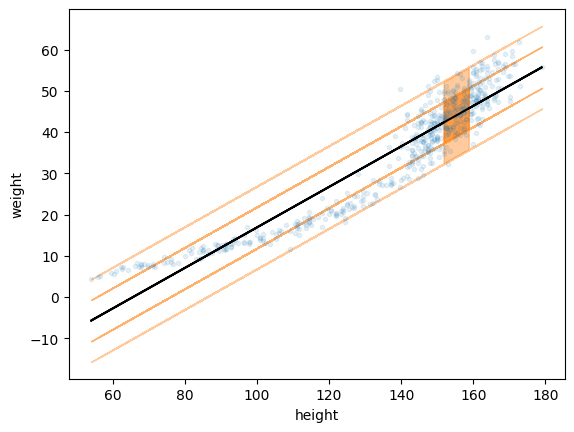

In [36]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_lba = az.extract(idata_lba)

μ_m = posterior_lba["μ"].mean("sample").values
σ_m = posterior_lba["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [37]:
pm.sample_posterior_predictive(
    idata_lba, model = howell_model, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

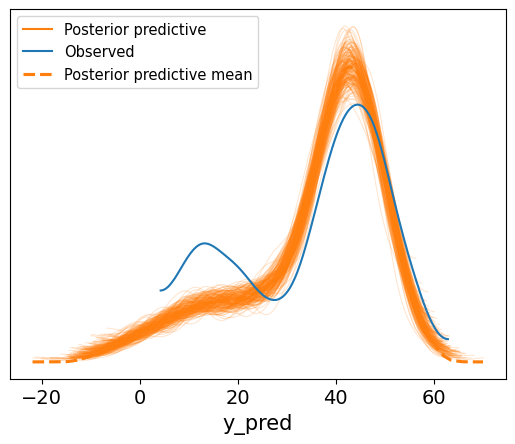

In [38]:
az.plot_ppc(idata_lba, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [6]:
with pm.Model() as model_howell2:

    #priors for line for our mean
    α = pm.Normal("α", sigma=5)
    β = pm.Normal("β", sigma=5)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(howell.height))

    #standard deviation line; this allows our variance to vary over th x values
    σ = pm.Deterministic("σ", γ + δ * howell.height)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_howell2 = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Text(0, 0.5, 'weight')

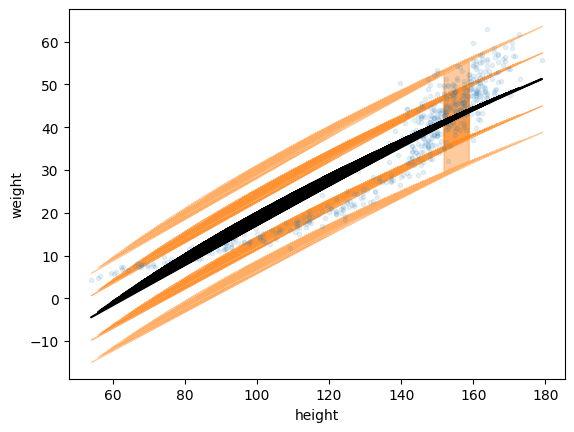

In [7]:
_, ax = plt.subplots()

ax.plot(howell.height, howell.weight, "C0.", alpha=0.1)

posterior_vvba = az.extract(idata_howell2)

μ_m = posterior_vvba["μ"].mean("sample").values
σ_m = posterior_vvba["σ"].mean("sample").values

ax.plot(howell.height, μ_m, c="k")
ax.fill_between(howell.height, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(howell.height, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [8]:
pm.sample_posterior_predictive(
    idata_howell2, model = model_howell2, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

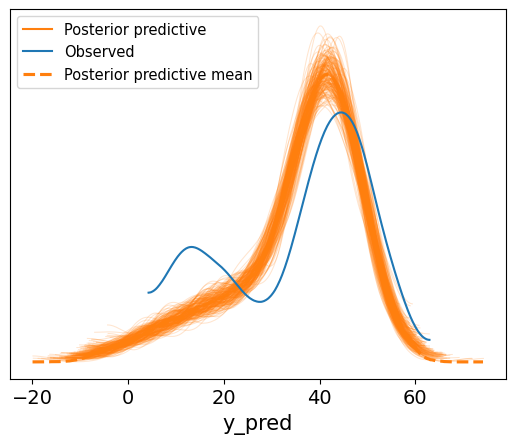

In [9]:
az.plot_ppc(idata_howell2, num_pp_samples=200, colors=["C1", "C0", "C1"])

The model is okay. It matches the shape of the data pretty well at the end, but doesn't match that first bump in the data. The peak is also too big and goes way higher than the data shows. However, the shape is pretty good.